<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/3mnist-multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/3mnist-multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A deep feedforward network with arbitrary depth

In this exercise we build a deep feedforward neural network to recognize handwrittne digits (the MNIST data). The code has many tweekable parameters, in particular the number and width of layers. But as you will see adding more layers slows down the convergence considerably.


### Packages

Since we are building the network from scratch (i.e. without using any framework) we take advantaged of the GPU on collab by using __cupy__ instead of __numpy__

In [1]:
using_cupy=1

if using_cupy:
 import cupy as np
else:
 import numpy as np

import matplotlib.pyplot as plt
import random
import tensorflow as tf

Important to be able to diplay matplotlib plots inline in the notebook

In [2]:
%matplotlib inline

## The data

The MNIST data are images of handwritten digits (0 to 9) and is available as an example dataset in keras. It contains a training set (60000) and a test set (10000). Each set contains pairs of (image,label) where the image is a gray scale with dimension 28x28 and the labels are from 0 to 9.



In [3]:
(img_train,label_train),(img_test_,label_test)=tf.keras.datasets.mnist.load_data()



11493376/11490434 [==============================] - 0s 0us/step


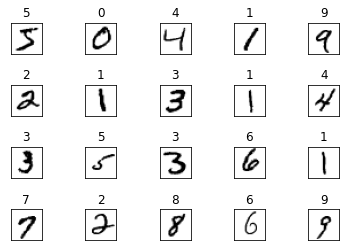

In [4]:
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)
for i in range(20):
            t=fig.add_subplot(4,5,i+1)
            # set the title of the image equal to its label
            t.set_title(str(label_train[i]))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img_train[i],cmap='gray_r')


### Data preprocessing

It is almost always advisable to divide the pixel values by 255 for better convergence. Also we convert the trainning labels to one-hot encoding. As an example run the code below to familiarize yourself with one-hot encoding.
#### One-hot example

In [5]:
## suppose we have 3 classes: 0,1,2
num_classes=3
x=[[1,2,0],[1,1,2]]
tf.one_hot(x,num_classes)

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]], dtype=float32)>

### Function to read the dataset

In [6]:
def load_dataset():

    (X,Y),(test_data,test_labels)=tf.keras.datasets.mnist.load_data()

    X=X.astype("float32")/255
    test_data=test_data.astype("float32")/255

    Y=Y.astype("float32")
    test_labels=test_labels.astype("float32")

   
    Y=tf.one_hot(Y,10)
    test_labels=test_labels.reshape(len(test_labels),1)
    ## tf.one_hot returns an eagerTensor type for Y
    ## convert to numpy array
    return X,Y.numpy(),test_data,test_labels


### Load and Inspect the Data

In [7]:
X, Y,test_data,test_labels = load_dataset()
print(X.shape)
print(Y.shape)
print(test_data.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 1)


### Activation Functions

Typically in such a setting the activation function for the inner layers could be sigmoid, relu,... and the activation for the last layer would be softmax which is a generalization of the sigmoid for multiclass inputs. Let $C$ be the set of classes and $c_1\in C$ a given class the probability of $c_1$ becomes (where $z_i$ is the logit corrsponding to class $i$)
\begin{align*}
softmax=\frac{e^{z_1\cdot w}}{\sum_i e^{z_i\cdot w}}
\end{align*}

In [8]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=-1).reshape(x.shape[0],1)


The usual cross Entropy cost. Unlike the evaluate function both the "true" labels and the output of our model are in one-hot encoding

In [9]:
def compute_cost(Y,b,w):
    
    m = Y.shape[0] # number of example

    # Compute the cross-entropy cost
    As=forward_propagation(X,b,w)
    # recall that As contains the "output" of all layers
    # including the input As[0] and the final output As[-1]
    output=As[-1]
    logprobs = np.log(output)*Y
    #+np.log(1-output)*(1-Y)
    cost = -np.sum(logprobs)/m

    count=0
    for i in range(output.shape[0]):
        if (np.argmax(output[i,:])==np.argmax(Y[i,:])):
            count=count+1

    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    #assert(isinstance(cost, float))
    
    return cost,count


The weights are initialized randomly and the biases are initially set to zero

In [10]:
def initialize_parameters(width):    
    weights=[]
    biases=[]
    for i in range(len(width)-1):
        w=np.random.randn(width[i],width[i+1])
        b=np.zeros((width[i+1],))
        weights.append(w)
        biases.append(b)

    return biases,weights


Forward propagation over all the layers but also retain the intermediate results.
For example below As[0] is the input, As[1] is the output of the first layer,..., and As[-1] (the last) is the output

In [11]:
def forward_propagation(X,biases,weights):
    a=X
    As=[X]
    para=zip(weights,biases)
    for i,(w,b) in enumerate(para):
       z=np.dot(a,w)+b
       if i==len(biases)-1:
         #a=np.array(tf.nn.softmax(np.asnumpy(z)).numpy())
         a=softmax(z)
       else:
         a=sigmoid(z)
       As.append(a)

    return As

## Backpropagation

Note how the gradient of a given layer depends on the gradient of the __next__ layer. This means that when computing the gradients we start from the __last__ layer and move __backwards__.
\begin{align*}
\Delta^l_{mn}&=\sum_k \Delta^{l+1}_{mk}W^l_{nk}\theta^l_{mn}\\
dW_{ij}&=\frac{1}{m}\sum_m\Delta^{l+1}_{mj}A^l_{mi}\\
dB_{j}&=\frac{1}{m}\sum_m\Delta^{l+1}_{mj}
\end{align*}

Or in matrix notation
\begin{align*}
\Delta^l&=\Delta^{l+1}\cdot (W^l)^T\theta^l\\
dW^l&=\frac{1}{m}(A^l)^T\cdot \Delta^{l+1}
\end{align*}

In [12]:
def backward_propagation(X,Y,biases,weights):
    
    As=forward_propagation(X,biases,weights)
    m = X.shape[0]
    
    nlayers=len(biases)
    # Error of the last layer
    dz=As[nlayers]-Y

    gradb=[]
    gradw=[]
    for i in range(nlayers,0,-1):
        db=np.sum(dz,axis=0,keepdims=True)/m
        dw=np.dot(As[i-1].T,dz)/m
        dz=np.dot(dz,weights[i-1].T)*As[i-1]*(1-As[i-1])
        gradb.insert(0,db)
        gradw.insert(0,dw)
    
    return gradb,gradw

In [13]:
def update_parameters(biases,weights, gradb,gradw, learning_rate):


    for i in range(len(biases)):
        weights[i]=weights[i]-learning_rate*gradw[i]
        biases[i]=biases[i]-learning_rate*gradb[i]

    return biases,weights

### Stochastic Gradient Descent

We deal with the input data in __random batches__. We select a set of random indices and take a slice from X and Y

In [14]:
def GD(X, Y, test_data,width,batch_size,num_iterations, learning_rate,print_cost=False):

    biases,weights=initialize_parameters(width)
    
    for i in range(0, num_iterations):
        cost,count = compute_cost(Y,biases,weights)
        for k in range(0,X.shape[0],batch_size):
            idx=[random.randint(0,Y.shape[0]-1) for s in range(batch_size)]
            yb=Y[idx,:]
            xb=X[idx,:]
            gradb,gradw=backward_propagation(xb,yb,biases,weights)
            biases,weights=update_parameters(biases,weights,gradb,gradw,learning_rate)    

        if i%1 ==0 : 
            #count_test=evaluate(test_data,test_labels,biases,weights)
            count=count/Y.shape[0]
            if using_cupy:
                print ("Epoch {}: cost={:.2f},train accuracy={:.2f}".
                       format(i,np.asnumpy(cost),np.asnumpy(count)))
            else:
                print ("Epoch {}: cost={:.2f},train accuracy={:.2f}".format(i,cost,count))
                
    return biases,weights

#### Run SGD

In [15]:
X, Y,test_data,test_labels = load_dataset()
X=X.reshape(60000,784)
test_data=test_data.reshape(10000,784)
## load_dataset returns objects as type numpy array
## we need to convert them to be used by cupy
if using_cupy:
   X=np.array(X)
   test_data=np.array(test_data)
   Y=np.array(Y)

n_x=X.shape[1]
n_y=Y.shape[1]
width=[n_x,128,64,n_y]

biases,weights= GD(X, Y,test_data,width,batch_size=512,learning_rate=3,
                num_iterations =10, print_cost=True)

Epoch 0: cost=8.33,train accuracy=0.09
Epoch 1: cost=0.51,train accuracy=0.84
Epoch 2: cost=0.37,train accuracy=0.89
Epoch 3: cost=0.31,train accuracy=0.91
Epoch 4: cost=0.27,train accuracy=0.92
Epoch 5: cost=0.24,train accuracy=0.93
Epoch 6: cost=0.22,train accuracy=0.94
Epoch 7: cost=0.20,train accuracy=0.94
Epoch 8: cost=0.18,train accuracy=0.95
Epoch 9: cost=0.17,train accuracy=0.95


### Evaluation

Returns the number of correct predictions. Note that the output of our model is in one-hot encoding so it has 10 columns and N rows where N is the number of data points whereas test_labels is NOT in one-hot encoding so it has a single column and N rows. For a given row i, argmax returns the column index which has the largest value, i.e. the largest likelyhood


In [16]:
def evaluate(test_data,test_labels,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    #the output is in one-hot encoding so it has 10 rows
    # and number of data columns where as test_tables 
    # is NOT in one-hot encoding so it has a single row
    for i in range(output.shape[0]):
        if np.argmax(output[i,:])==test_labels[i,0]:
            count=count+1
    return count/test_labels.shape[0]

In [17]:
evaluate(test_data,test_labels,biases,weights)

0.9325

### Missclassified inputs

This function plots some of the misclassified data in order for us to have an idea what when wrong.

In [18]:
def print_misclassified(test_data,test_labels,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    fig=plt.figure()
    fig.tight_layout()
    plt.subplots_adjust( wspace=1, hspace=1)

    for i in range(output.shape[0]):
        label=np.argmax(output[i,:])
        if label != test_labels[i,0]:
            if count>40:
                break
            subfig=count%40+1
            count=count+1
            img=np.asnumpy(test_data[i,:]).reshape(28,28)
            t=fig.add_subplot(4,10,subfig)
            #t.set_title(str(i))
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')



Prints some of the misclassified digits. The top on each digit shows the (wrong) prediction.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


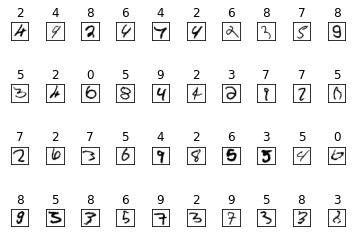

In [19]:
print_misclassified(test_data,test_labels,biases,weights)
